In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, GlobalAveragePooling1D,
                                     Dense, Dropout, LayerNormalization, BatchNormalization, MultiHeadAttention,
                                     Input, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os


In [2]:
# Configuration
img_size = 128
batch_size = 32

In [3]:
# Custom CNN block (keeps accuracy high)
# def custom_cnn(x):
#     x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D()(x)

#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D()(x)

#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D()(x)

#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D()(x)

#     x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)  # <-- changed 'inputs' to 'x'
#     x = BatchNormalization()(x)
#     x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Dropout(0.25)(x)

#     x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Dropout(0.3)(x)

#     x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = BatchNormalization()(x)
#     x = GlobalAveragePooling2D()(x)

#     return x

In [4]:
# Custom CNN block (improved for higher accuracy)
def custom_cnn(x):
    # Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    # Block 4
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)

    # Global pooling instead of Flatten → better generalization
    x = GlobalAveragePooling2D()(x)

    return x


In [5]:
#  Transformer block (preserve attention capacity)
# def tiny_transformer_block(x, embed_dim=128, num_heads=2, ff_dim=256, dropout=0.1):
#     attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
#     attn_output = Dropout(dropout)(attn_output)
#     x = LayerNormalization(epsilon=1e-6)(x + attn_output)

#     ffn_output = tf.keras.Sequential([
#         Dense(ff_dim, activation='relu'),
#         Dense(embed_dim),
#     ])(x)
#     ffn_output = Dropout(dropout)(ffn_output)
#     x = LayerNormalization(epsilon=1e-6)(x + ffn_output)
#     return x

In [6]:
#  Final model
def build_model(num_classes):
    inputs = Input(shape=(img_size, img_size, 3))
    x = custom_cnn(inputs)                       # Output shape ≈ (8x8x128)
    #x = Reshape((64, 128))(x)                    # Flatten spatial → sequence
    #x = tiny_transformer_block(x)
    #x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)


In [7]:
# Paths (Colab storage)
train_path = "C:\\Users\\SATARUPA\\OneDrive\\Desktop\\Tiny ML\\Hydrophobicity Classes Photos\\train"
val_path = "C:\\Users\\SATARUPA\\OneDrive\\Desktop\\Tiny ML\\Hydrophobicity Classes Photos\\validation"


In [8]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    
    shuffle=True
)
val_data = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)
print(train_data[1])

Found 2800 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
(array([[[[0.71684843, 0.27632353, 0.15955669],
         [0.6228857 , 0.17649014, 0.06162497],
         [0.65171057, 0.22027598, 0.10041169],
         ...,
         [0.32941177, 0.2509804 , 0.05490196],
         [0.32941177, 0.2509804 , 0.05490196],
         [0.32941177, 0.2509804 , 0.05490196]],

        [[0.73609865, 0.31002548, 0.196656  ],
         [0.6328813 , 0.20050353, 0.0825131 ],
         [0.66451925, 0.24184541, 0.11955775],
         ...,
         [0.33593974, 0.2531564 , 0.05707794],
         [0.33692908, 0.25348616, 0.05740773],
         [0.33791843, 0.25381598, 0.05773751]],

        [[0.68862176, 0.28077817, 0.17555247],
         [0.6377752 , 0.22003224, 0.09837016],
         [0.6499038 , 0.22731265, 0.11061769],
         ...,
         [0.34435618, 0.25808167, 0.06200323],
         [0.34501576, 0.25874123, 0.0626628 ],
         [0.34567532, 0.2594008 , 0.06332237]],

        ...,

        

In [9]:
# Build and compile
model = build_model(num_classes=train_data.num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0     

In [17]:
# Callbacks
checkpoint = ModelCheckpoint(
    "C:\\Users\\SATARUPA\\OneDrive\\Desktop\\Tiny ML\\model_accurate_compact.keras",
    save_best_only=True, monitor="val_accuracy", mode="max", verbose=1
)
#early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [18]:
# Training
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[early_stop, checkpoint, lr_reducer]
)


Epoch 1/20
88/88 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.8850
Epoch 1: val_accuracy improved from -inf to 0.64857, saving model to C:\Users\SATARUPA\OneDrive\Desktop\Tiny ML\model_accurate_compact.keras
88/88 [==============================] - 20s 214ms/step - loss: 0.3174 - accuracy: 0.8850 - val_loss: 1.0387 - val_accuracy: 0.6486 - lr: 5.0000e-04
Epoch 2/20
88/88 [==============================] - ETA: 0s - loss: 0.3118 - accuracy: 0.8886
Epoch 2: val_accuracy did not improve from 0.64857
88/88 [==============================] - 18s 209ms/step - loss: 0.3118 - accuracy: 0.8886 - val_loss: 1.6877 - val_accuracy: 0.5486 - lr: 5.0000e-04
Epoch 3/20
88/88 [==============================] - ETA: 0s - loss: 0.2964 - accuracy: 0.8925
Epoch 3: val_accuracy improved from 0.64857 to 0.73571, saving model to C:\Users\SATARUPA\OneDrive\Desktop\Tiny ML\model_accurate_compact.keras
88/88 [==============================] - 19s 211ms/step - loss: 0.2964 - accuracy: 0

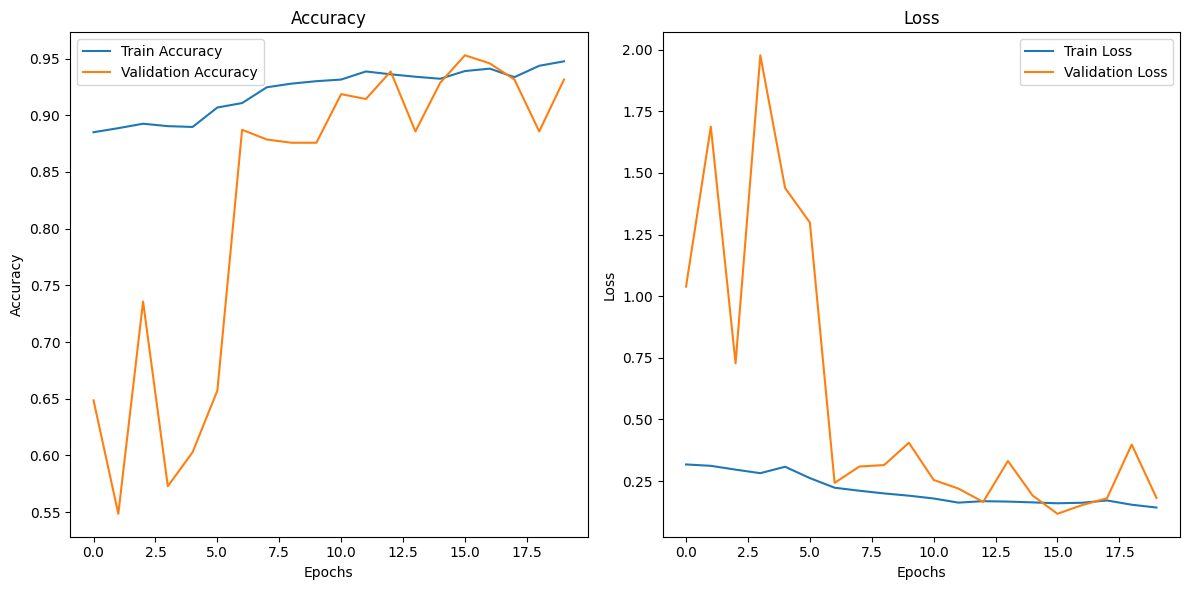

In [19]:
# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Define test path
test_path = "C:\\Users\\SATARUPA\\OneDrive\\Desktop\\Tiny ML\\Hydrophobicity Classes Photos\\test"

# Test data generator (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test data
test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1036 images belonging to 7 classes.


In [21]:
# Load the best saved model
model = tf.keras.models.load_model("C:\\Users\\SATARUPA\\OneDrive\\Desktop\\Tiny ML\\model_accurate_compact.keras")

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_data)
print(f"\n Test Accuracy: {test_acc * 100:.2f}%")

# Load the .keras model
model = tf.keras.models.load_model("C:\\Users\\SATARUPA\\OneDrive\\Desktop\\Tiny ML\\model_accurate_compact.keras")

# Create TFLite converter from the loaded model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

33/33 [==============================] - 3s 54ms/step - loss: 0.1393 - accuracy: 0.9373

 Test Accuracy: 93.73%


In [ ]:
# Apply quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()
SS
# Save the compressed .tflite model
with open("C:\\Users\\SATARUPA\\OneDrive\\Desktop\\Tiny ML\\quantized_model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\SATARUPA\AppData\Local\Temp\tmpyvwcue71\assets


INFO:tensorflow:Assets written to: C:\Users\SATARUPA\AppData\Local\Temp\tmpyvwcue71\assets


In [22]:
import os

model_path = r"C:\Users\SATARUPA\OneDrive\Desktop\Tiny ML\quantized_model.tflite"
model_size_bytes = os.path.getsize(model_path)
model_size_mb = model_size_bytes / (1024 * 1024)
print(f"Quantized model size: {model_size_mb:.2f} MB")

Quantized model size: 1.17 MB
